In [ ]:
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 14.6 MB/s eta 0:00:00


[*********************100%***********************]  1 of 1 completed


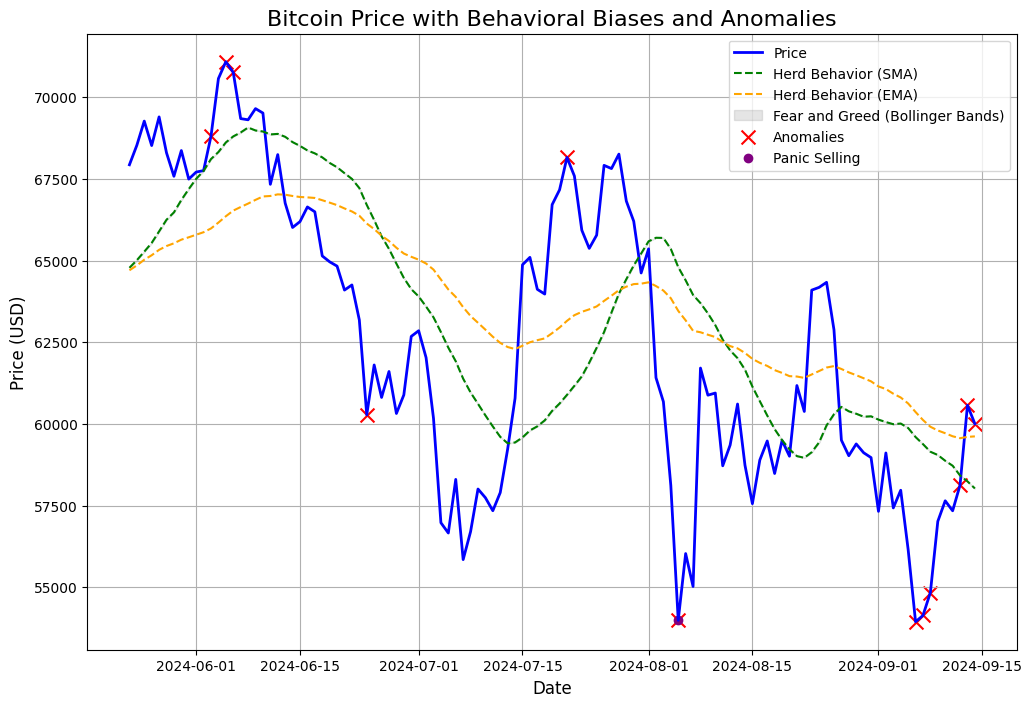

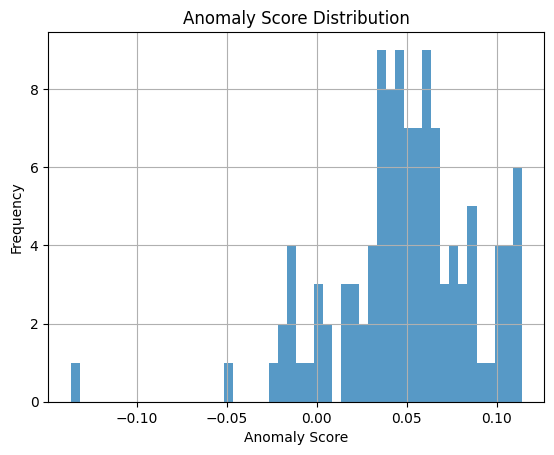

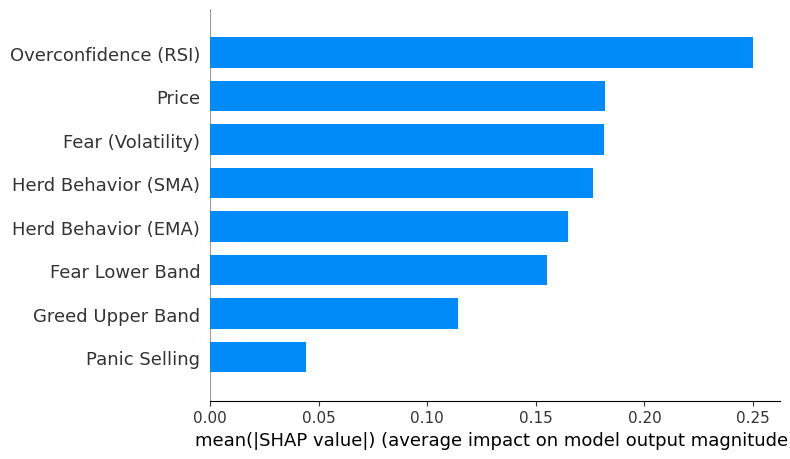

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import shap

# Step 1: Fetch Bitcoin data
ticker = 'BTC-USD'
bitcoin_data = yf.download(ticker, start='2023-09-15', end='2024-09-15')

# Step 2: Behavioral Bias Indicators (as before)
bitcoin_data['SMA_20'] = bitcoin_data['Close'].rolling(window=20).mean()
bitcoin_data['EMA_50'] = bitcoin_data['Close'].ewm(span=50, adjust=False).mean()
bitcoin_data['volatility'] = bitcoin_data['Close'].pct_change().rolling(window=20).std()
bitcoin_data['middle_band'] = bitcoin_data['Close'].rolling(window=20).mean()
bitcoin_data['upper_band'] = bitcoin_data['middle_band'] + 2 * bitcoin_data['volatility']
bitcoin_data['lower_band'] = bitcoin_data['middle_band'] - 2 * bitcoin_data['volatility']

# RSI for Overconfidence/Panic
delta = bitcoin_data['Close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
rs = avg_gain / avg_loss
bitcoin_data['RSI'] = 100 - (100 / (1 + rs))

# Panic Selling
bitcoin_data['price_change'] = bitcoin_data['Close'].pct_change()
bitcoin_data['volume_change'] = bitcoin_data['Volume'].pct_change()
bitcoin_data['panic_selling'] = ((bitcoin_data['price_change'] < -0.05) & (bitcoin_data['volume_change'] > 0.5)).astype(int)

# Anchoring
bitcoin_data['deviation_from_high'] = (bitcoin_data['Close'] - bitcoin_data['Close'].rolling(window=252).max()) / bitcoin_data['Close'].rolling(window=252).max()
bitcoin_data['deviation_from_low'] = (bitcoin_data['Close'] - bitcoin_data['Close'].rolling(window=252).min()) / bitcoin_data['Close'].rolling(window=252).min()

# Drop NaN values
bitcoin_data.dropna(inplace=True)

# Step 3: Isolation Forest for Anomaly Detection
features = ['Close', 'SMA_20', 'EMA_50', 'volatility', 'RSI', 'upper_band', 'lower_band', 'panic_selling']
iso_forest = IsolationForest(contamination=0.1, random_state=42)
iso_forest.fit(bitcoin_data[features])

# Anomaly predictions and anomaly scores
bitcoin_data['anomaly'] = iso_forest.predict(bitcoin_data[features])
bitcoin_data['anomaly_score'] = iso_forest.decision_function(bitcoin_data[features])

# Filter anomalies
anomalies = bitcoin_data[bitcoin_data['anomaly'] == -1]

# Step 4: Visualization
plt.figure(figsize=(12, 8))
plt.plot(bitcoin_data.index, bitcoin_data['Close'], label='Price', color='blue', linewidth=2)
plt.plot(bitcoin_data.index, bitcoin_data['SMA_20'], label='Herd Behavior (SMA)', color='green', linestyle='--')
plt.plot(bitcoin_data.index, bitcoin_data['EMA_50'], label='Herd Behavior (EMA)', color='orange', linestyle='--')
plt.fill_between(bitcoin_data.index, bitcoin_data['lower_band'], bitcoin_data['upper_band'], color='gray', alpha=0.2, label='Fear and Greed (Bollinger Bands)')
plt.scatter(anomalies.index, anomalies['Close'], color='red', label='Anomalies', marker='x', s=100)
plt.scatter(bitcoin_data[bitcoin_data['panic_selling'] == 1].index, bitcoin_data['Close'][bitcoin_data['panic_selling'] == 1], label='Panic Selling', color='purple', marker='o')
plt.title('Bitcoin Price with Behavioral Biases and Anomalies', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

# Step 5: Anomaly Score Histogram
plt.hist(bitcoin_data['anomaly_score'], bins=50, alpha=0.75)
plt.title('Anomaly Score Distribution')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Step 6: Explainable AI (SHAP for Isolation Forest)
explainer = shap.Explainer(iso_forest, bitcoin_data[features])
shap_values = explainer(bitcoin_data[features])

# SHAP summary plot for explainability with behavioral names
shap.summary_plot(shap_values, feature_names=['Price', 'Herd Behavior (SMA)', 'Herd Behavior (EMA)', 'Fear (Volatility)', 'Overconfidence (RSI)', 'Greed Upper Band', 'Fear Lower Band', 'Panic Selling'], plot_type="bar")


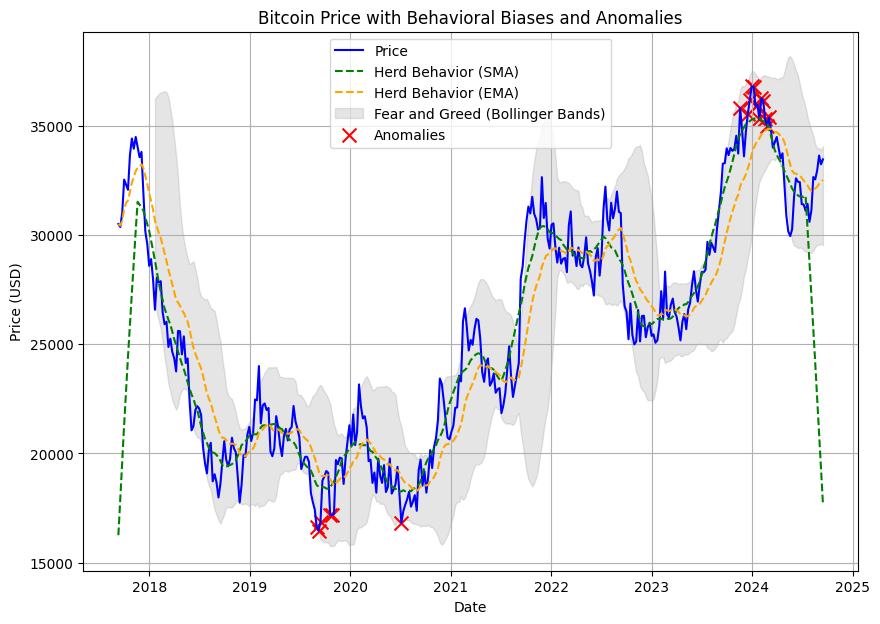

TypeError: The passed model is not callable and cannot be analyzed directly with the given masker! Model: IsolationForest(contamination=0.05)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import IsolationForest
import shap

# Simulated Bitcoin data (just as a placeholder)
# Here, a real Bitcoin dataset would be loaded and preprocessed
np.random.seed(42)
dates = pd.date_range('2017-09-07', '2024-09-15', freq='W')
price = np.cumsum(np.random.randn(len(dates)) * 1000) + 30000  # Simulated prices
behavior_metrics = pd.DataFrame({
    'Date': dates,
    'Price': price,
    'Herd_Behavior_SMA': np.convolve(price, np.ones(20)/20, mode='same'),
    'Herd_Behavior_EMA': pd.Series(price).ewm(span=20).mean(),
    'Fear_Greed_Bollinger_Upper': pd.Series(price).rolling(window=20).mean() + 2 * pd.Series(price).rolling(window=20).std(),
    'Fear_Greed_Bollinger_Lower': pd.Series(price).rolling(window=20).mean() - 2 * pd.Series(price).rolling(window=20).std(),
})

# Step 1: Train Isolation Forest for Anomaly Detection
iso_forest = IsolationForest(contamination=0.05)
behavior_metrics['anomaly'] = iso_forest.fit_predict(behavior_metrics[['Price']])

# Step 2: Plot price, anomalies, and behavioral biases
plt.figure(figsize=(10, 7))
plt.plot(behavior_metrics['Date'], behavior_metrics['Price'], label='Price', color='blue')
plt.plot(behavior_metrics['Date'], behavior_metrics['Herd_Behavior_SMA'], '--', label='Herd Behavior (SMA)', color='green')
plt.plot(behavior_metrics['Date'], behavior_metrics['Herd_Behavior_EMA'], '--', label='Herd Behavior (EMA)', color='orange')
plt.fill_between(behavior_metrics['Date'], behavior_metrics['Fear_Greed_Bollinger_Upper'],
                 behavior_metrics['Fear_Greed_Bollinger_Lower'], color='gray', alpha=0.2, label='Fear and Greed (Bollinger Bands)')
plt.scatter(behavior_metrics[behavior_metrics['anomaly'] == -1]['Date'],
            behavior_metrics[behavior_metrics['anomaly'] == -1]['Price'],
            color='red', label='Anomalies', marker='x', s=100)
plt.title('Bitcoin Price with Behavioral Biases and Anomalies')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

# Step 3: Explain anomalies using SHAP
# Generating SHAP values for a mock explainer (since this is simulated)
explainer = shap.Explainer(iso_forest, behavior_metrics[['Price']])
shap_values = explainer(behavior_metrics[['Price']])

# Plot SHAP summary for anomalies
shap.summary_plot(shap_values[behavior_metrics['anomaly'] == -1], behavior_metrics[['Price']])



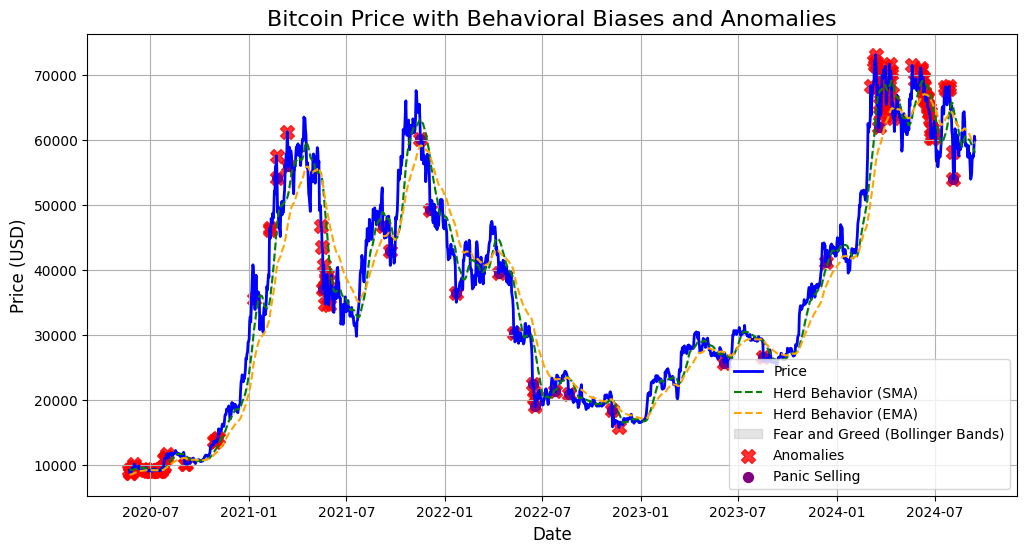

In [ ]:
import matplotlib.pyplot as plt

# Ensure you are using a subset of data or reasonable range to avoid large plots
# Adjusting figure size and setting DPI
plt.figure(figsize=(12, 6), dpi=100)

# Main Price plot
plt.plot(bitcoin_data.index, bitcoin_data['Close'], label='Price', color='blue', linewidth=2)

# Behavioral indicators
plt.plot(bitcoin_data.index, bitcoin_data['SMA_20'], label='Herd Behavior (SMA)', color='green', linestyle='--')
plt.plot(bitcoin_data.index, bitcoin_data['EMA_50'], label='Herd Behavior (EMA)', color='orange', linestyle='--')

# Bollinger Bands
plt.fill_between(bitcoin_data.index, bitcoin_data['lower_band'], bitcoin_data['upper_band'], color='gray', alpha=0.2, label='Fear and Greed (Bollinger Bands)')

# Anomalies with larger markers
plt.scatter(anomalies.index, anomalies['Close'], color='red', label='Anomalies', marker='X', s=100, alpha=0.8)

# Panic Selling points
plt.scatter(bitcoin_data[bitcoin_data['panic_selling'] == 1].index, bitcoin_data['Close'][bitcoin_data['panic_selling'] == 1], label='Panic Selling', color='purple', marker='o', s=50)

# Title and labels
plt.title('Bitcoin Price with Behavioral Biases and Anomalies', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)

# Add legend and grid
plt.legend()
plt.grid(True)

# Display the plot
plt.show()


In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# Use ARIMA for price prediction (train on 80% of the data)
train_data = bitcoin_data['Close'][:int(0.8*len(bitcoin_data))]
test_data = bitcoin_data['Close'][int(0.8*len(bitcoin_data)):]

# Fit ARIMA model (you can tune p, d, q)
model = ARIMA(train_data, order=(5, 1, 0))  # p, d, q can be tuned
model_fit = model.fit()

# Predict future prices
predicted_prices = model_fit.forecast(steps=len(test_data))

# Create a new DataFrame to store real vs predicted
predicted_df = bitcoin_data[int(0.8*len(bitcoin_data)):].copy()
predicted_df['Predicted_Close'] = predicted_prices.values


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [ ]:
# Apply Isolation Forest on predicted prices
iso_forest_pred = IsolationForest(contamination=0.05)
predicted_df['anomaly_predicted'] = iso_forest_pred.fit_predict(predicted_df[['Predicted_Close']])


In [ ]:
plt.figure(figsize=(12, 7))

# Plot real prices and anomalies
plt.plot(bitcoin_data['Date'], bitcoin_data['Close'], label='Real Price', color='blue')
plt.scatter(bitcoin_data[bitcoin_data['anomaly'] == -1]['Date'],
            bitcoin_data[bitcoin_data['anomaly'] == -1]['Close'],
            color='red', label='Real Anomalies', marker='x', s=100)

# Plot predicted prices and predicted anomalies
plt.plot(predicted_df['Date'], predicted_df['Predicted_Close'], label='Predicted Price', color='green')
plt.scatter(predicted_df[predicted_df['anomaly_predicted'] == -1]['Date'],
            predicted_df[predicted_df['anomaly_predicted'] == -1]['Predicted_Close'],
            color='orange', label='Predicted Anomalies', marker='o', s=100)

plt.title('Real vs Predicted Prices and Anomalies')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()


KeyError: 'Date'

<Figure size 1200x700 with 0 Axes>